# QM9 semi-supervised pipeline

This notebook follows most steps as described in the report. It will not include the random hyperparameter search, as this takes a very long time. The defined models in this notebook uses the best parameters found in this search. To See the full hyperparameter search setup, see `optimized_parameters_eval_new_targets.sh`. 

The structure of this notebook is as follows:

1. **Dataloading**
    - Loads the QM9 dataset
2. **DataVisualization**
    - Basic visualisation of the dataset
3. **Model Setup**
    - Defines the setup of our three models: Supervised Ensemble (Baseline), Mean Teachers, N-CPS
4. **Training and evaluation over different labeled/unlabeled splits**
    - Trains and evaluates each model on 5 splits, [0.5,1,2,5,8] 
5. **Model evaluation on test-set for 1% labeled training data**
    - Trains and tests the models on  
    - **Trenger vi det her?**
6. **Statistical comparrison of models**
    - Compares the models using a `statistical test`
7. **Summary**


As running this notebook locally is temporally unfeasable (atleast on ours), we have included the options to both run a subset of the data, or load the results from our main training run.

In [102]:
# Change these parameters to run a subset of the data, or load the results from our main training run.
# Set RUN_EXPERIMENTS to True and PERCENT_SUBSET to 1 to reproduce our full run.
RUN_EXPERIMENTS = False      # Set to False if you only want to re-use cached json results
PERCENT_SUBSET = 1       # Subset of data to use for efficiency

# Change this to your path
ROOT_DIRECTORY = "/Users/Magnus/Documents/7. sem/Deep Learnig/Project-2-gnn-and-semi_supervised"

**Notebook map / code sources**

- **Environment + data wiring (Sections 1–2):** wraps `src/qm9.py`'s `QM9DataModule` helpers and the visualization utilities defined in this notebook.
- **Trainer configs (Section 3):** thin glue around `src/models.py` (GCN backbone) and `src/trainer.py` (SemiSupervisedEnsemble, MeanTeacherTrainer, NCPSTrainer).
- **Baseline comparison (Section 4):** parses `results/Compare Original vs GCN Results.json` to highlight why the improved GCN settings are adopted elsewhere.
- **Experiment loop (Section 5):** calls directly into the trainer abstractions from `src/trainer.py` and reuses `QM9DataModule` loaders.
- **Result plotting & stats (Section 6):** pure notebook logic that feeds off the DataFrame outputs saved to `outputs/notebooks/` plus cached sweeps in `results/`.




**Environment setup**

See `README.md`

In [103]:
# Imports
import os
import sys
import json
from pathlib import Path
from collections import OrderedDict
from functools import partial
from itertools import combinations
from contextlib import contextmanager, nullcontext
import time

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from tqdm.auto import tqdm

try:
    from torch_geometric.utils import to_networkx
    from torch_geometric.datasets import QM9 as RawQM9
except ModuleNotFoundError as exc:
    raise ModuleNotFoundError(
        "torch_geometric is missing. Install the dependencies locally via `pip install -r requirements.txt` before running the notebook."
    ) from exc
%config InlineBackend.figure_format='retina'
# Data and model imports
from qm9 import QM9DataModule
from trainer import SemiSupervisedEnsemble, MeanTeacherTrainer, NCPSTrainer
from models import GCN
from utils import seed_everything


In [104]:
# Get directories and device
DEFAULT_ROOT = Path(ROOT_DIRECTORY)
PROJECT_CANDIDATES = [
    Path(os.getenv("PROJECT_ROOT")) if os.getenv("PROJECT_ROOT") else None,
    DEFAULT_ROOT,
    Path.cwd(),
]

repo_root = None
for candidate in PROJECT_CANDIDATES:
    if candidate is None:
        continue
    candidate = candidate.expanduser().resolve()
    if candidate.exists() and candidate.name == "Project-2-gnn-and-semi_supervised":
        repo_root = candidate
        break

if repo_root is None:
    repo_root = Path.cwd().resolve()

os.chdir(repo_root)
src_root = repo_root / "src"
if str(src_root) not in sys.path:
    sys.path.append(str(src_root))

data_dir = repo_root / "data"
data_dir.mkdir(exist_ok=True)


def resolve_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    mps_available = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    if mps_available:
        return torch.device("mps")
    return torch.device("cpu")


DEVICE = resolve_device()
torch.set_float32_matmul_precision("medium") if hasattr(torch, "set_float32_matmul_precision") else None
sns.set_theme(style="whitegrid")

print(f"Using repo root: {repo_root}")
print(f"Running on device: {DEVICE}")



Using repo root: /Users/Magnus/Documents/7. sem/Deep Learnig/Project-2-gnn-and-semi_supervised
Running on device: mps


## Experiment controls




In [105]:
LABELED_SPLITS_PCT = [0.5, 1, 2, 5, 8]
LABELED_SPLITS = [pct / 100 for pct in LABELED_SPLITS_PCT]
TRAIN_FRACTION = 0.8
VAL_FRACTION = 0.1
TEST_FRACTION = 0.1

BATCH_SIZE_LABELED = 64
BATCH_SIZE_INFER = 1024
NUM_WORKERS = 2             # bump to match hardware; >=1 because datamodule uses persistent workers
GLOBAL_SEED = 0
FORCE_DETERMINISTIC = False
seed_everything(GLOBAL_SEED, FORCE_DETERMINISTIC)

TOTAL_EPOCHS = 100
VALIDATION_INTERVAL = 3
ENABLE_TQDM = True          

RESULTS_CACHE = repo_root / "outputs" / "notebooks" / "semisupervised_results.csv"
RESULTS_CACHE.parent.mkdir(parents=True, exist_ok=True)
LABEL_SWEEP_RESULTS = repo_root / "results" / "gcn_label_sweep_test_results_target2_2.json"
FINAL_TEST_RESULTS = repo_root / "results" / "gcn_final_test_target2_results.json"
COMPARE_RESULTS_PATH = repo_root / "results" / "Compare Original vs GCN Results.json"

print(f"Labeled fractions (%): {LABELED_SPLITS_PCT}")
print(f"Subset percent p: {PERCENT_SUBSET*100:.1f}% | Epochs: {TOTAL_EPOCHS}")



Labeled fractions (%): [0.5, 1, 2, 5, 8]
Subset percent p: 100.0% | Epochs: 100


## Helper Functions

In [106]:
def _tqdm_kwargs(**kwargs):
    base = {"dynamic_ncols": True}
    base.update(kwargs)
    return base


def progress_iter(iterable, **kwargs):
    if ENABLE_TQDM and tqdm is not None:
        return tqdm(iterable, **_tqdm_kwargs(**kwargs))
    return iterable


@contextmanager
def progress_task(total=1, **kwargs):
    if ENABLE_TQDM and tqdm is not None:
        config = _tqdm_kwargs(total=total, **kwargs)
        with tqdm(**config) as bar:
            bar.update(0)  # force initial render so the bar is visible immediately
            yield bar
    else:
        yield None


def load_label_sweep_plot_df(json_path: Path) -> pd.DataFrame:
    if not json_path.exists():
        raise FileNotFoundError(f"Label sweep results file not found: {json_path}")
    with json_path.open("r") as handle:
        payload = json.load(handle)
    rows = []
    for method, entries in payload.get("data", {}).items():
        for entry in entries:
            rows.append(
                {
                    "method": method,
                    "labeled_fraction_pct": float(entry["label_pct"]),
                    "plot_metric": float(entry["test_loss"]),
                }
            )
    df = pd.DataFrame(rows)
    df.sort_values(["method", "labeled_fraction_pct"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


def load_final_test_results_df(json_path: Path) -> pd.DataFrame:
    if not json_path.exists():
        raise FileNotFoundError(f"Final test results file not found: {json_path}")
    with json_path.open("r") as handle:
        payload = json.load(handle)
    method_alias = {
        "Supervised Baseline": "Supervised Ensemble",
        "n-CPS Ensemble": "n-CPS",
    }
    rows = []
    for entry in payload.get("results", []):
        rows.append(
            {
                "method": method_alias.get(entry["method"], entry["method"]),
                "test_metric": float(entry["test_mse"]),
                "source_method": entry["method"],
            }
        )
    df = pd.DataFrame(rows)
    df.sort_values(["method"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


COMPARISON_VARIANTS = OrderedDict(
    [
        (("Original_GCN", "QM9 original"), "Original GCN · QM9 old"),
        (("Original_GCN", "QM9 new"), "Original GCN · QM9 new"),
        (("Improved GCN", "QM9 original"), "Improved GCN · QM9 old"),
        (("Improved GCN", "QM9 new"), "Improved GCN · QM9 new"),
    ]
)


def load_baseline_comparison_records(json_path: Path = COMPARE_RESULTS_PATH) -> list[dict]:
    if not json_path.exists():
        raise FileNotFoundError(f"Comparison results file not found: {json_path}")
    with json_path.open("r") as handle:
        payload = json.load(handle)
    records = []
    seen_keys: set[tuple[str, str]] = set()
    for entry in payload.get("results", []):
        if entry.get("trainer") != "Supervised Ensemble":
            continue
        key = (entry.get("model"), entry.get("dataset_variant"))
        if key not in COMPARISON_VARIANTS:
            continue
        history = entry.get("val_history", [])
        history_df = pd.DataFrame(history)
        if history_df.empty:
            continue
        final_val = float(entry.get("val_mse", history_df["val_mse"].iloc[-1]))
        records.append(
            {
                "model": entry.get("model"),
                "dataset_variant": entry.get("dataset_variant"),
                "label": COMPARISON_VARIANTS[key],
                "final_val_mse": final_val,
                "history": history_df,
            }
        )
        seen_keys.add(key)
    missing = [label for key, label in COMPARISON_VARIANTS.items() if key not in seen_keys]
    if missing:
        raise ValueError(f"Missing comparison entries for: {missing}")
    ordered = []
    for key in COMPARISON_VARIANTS:
        for rec in records:
            if (rec["model"], rec["dataset_variant"]) == key:
                ordered.append(rec)
                break
    return ordered



In [107]:
QM9_TOTAL_SAMPLES = None

def infer_total_qm9_samples() -> int:
    """Return the total number of molecules available in QM9 (cached)."""
    global QM9_TOTAL_SAMPLES
    if QM9_TOTAL_SAMPLES is not None:
        return QM9_TOTAL_SAMPLES

    raw_cache = data_dir / "raw" / "qm9_v3.pt"
    if raw_cache.exists():
        try:
            maybe_data = torch.load(raw_cache, map_location="cpu")
            if isinstance(maybe_data, tuple) and len(maybe_data) == 2:
                _, slices = maybe_data
                QM9_TOTAL_SAMPLES = int(slices["y"][-1])
            elif isinstance(maybe_data, dict) and "y" in maybe_data:
                QM9_TOTAL_SAMPLES = int(maybe_data["y"].shape[0])
            else:
                raise ValueError("Unexpected qm9_v3.pt structure")
        except Exception as exc:
            print(f"Could not infer total samples from cache ({exc}); loading RawQM9 instead.")
            dataset = RawQM9(root=str(data_dir))
            QM9_TOTAL_SAMPLES = len(dataset)
    else:
        dataset = RawQM9(root=str(data_dir))
        QM9_TOTAL_SAMPLES = len(dataset)
    return QM9_TOTAL_SAMPLES


def subset_size_from_percent(p: float) -> int:
    if not (0 < p <= 1):
        raise ValueError("p must lie in the interval (0, 1].")
    total = infer_total_qm9_samples()
    return max(1, int(total * p))



## 1. Dataloading

We reuse `QM9DataModule` exactly as defined in `src/qm9.py`. The data is split to keep **80%** of the dataset for training (split into labeled vs. unlabeled), while the last 20% is evenly split between validation and test data.


In [108]:
def make_splits(labeled_fraction: float) -> list[float]:
    if labeled_fraction >= TRAIN_FRACTION:
        raise ValueError("Labeled fraction must be smaller than the total train fraction (0.8).")
    unlabeled_fraction = TRAIN_FRACTION - labeled_fraction
    return [unlabeled_fraction, labeled_fraction, VAL_FRACTION, TEST_FRACTION]


def build_datamodule(labeled_fraction: float, seed: int = GLOBAL_SEED, show_progress: bool = False) -> QM9DataModule:
    splits = make_splits(labeled_fraction)
    subset_size = subset_size_from_percent(PERCENT_SUBSET)
    desc = f"QM9 data @ {labeled_fraction*100:.1f}% labeled"
    context = progress_task(total=1, desc=desc, leave=False) if show_progress else nullcontext()
    with context as bar:
        dm = QM9DataModule(
            target=2,
            data_dir=str(data_dir),
            batch_size_train=BATCH_SIZE_LABELED,
            batch_size_inference=BATCH_SIZE_INFER,
            num_workers=NUM_WORKERS,
            splits=splits,
            seed=seed,
            subset_size=subset_size,
            data_augmentation=False,
        )
        if bar:
            bar.update(1)
    return dm


def summarize_datamodule(dm: QM9DataModule) -> dict:
    total_used = (
        len(dm.data_train_labeled)
        + len(dm.data_train_unlabeled)
        + len(dm.data_val)
        + len(dm.data_test)
    )
    return {
        "subset_p": PERCENT_SUBSET,
        "subset_size": total_used,
        "labeled": len(dm.data_train_labeled),
        "unlabeled": len(dm.data_train_unlabeled),
        "val": len(dm.data_val),
        "test": len(dm.data_test),
        "y_mean": dm.y_mean.item(),
        "y_std": dm.y_std.item(),
    }


def preview_datamodule(labeled_fraction: float = LABELED_SPLITS[1]):
    dm = build_datamodule(labeled_fraction, show_progress=ENABLE_TQDM)
    summary = summarize_datamodule(dm)
    display(pd.Series(summary, name=f"split @ {labeled_fraction*100:.1f}% labeled"))
    return dm


dm_preview = preview_datamodule()



Could not infer total samples from cache (Unexpected qm9_v3.pt structure); loading RawQM9 instead.


QM9 data @ 1.0% labeled:   0%|          | 0/1 [00:00<?, ?it/s]

Target normalization (train only): mean=-6.5459, std=0.6141
QM9 dataset loaded with 1308 labeled, 103356 unlabeled, 13083 validation, and 13084 test samples.
Batch sizes: labeled=64, unlabeled=4922


subset_p            1.000000
subset_size    130831.000000
labeled          1308.000000
unlabeled      103356.000000
val             13083.000000
test            13084.000000
y_mean             -6.545867
y_std               0.614144
Name: split @ 1.0% labeled, dtype: float64

## 2. Data visualization

We inspect a single molecule graph and the (de-normalized) target distribution to make sure everything looks sensible before launching training runs.


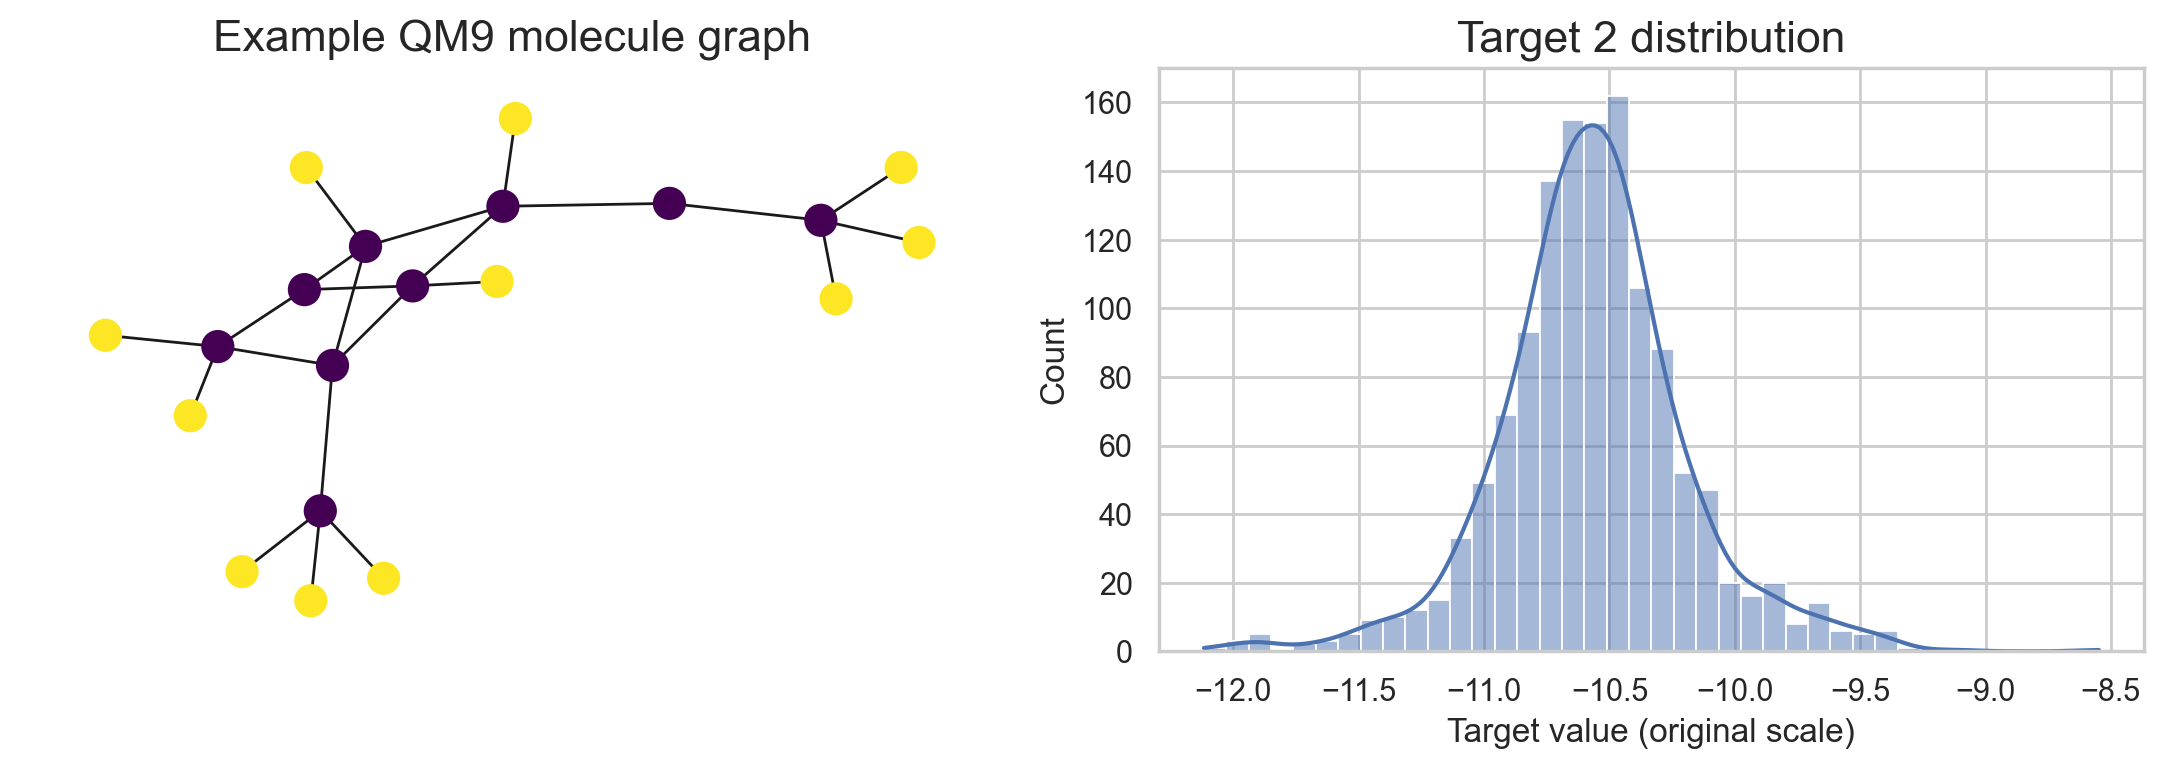

In [109]:
sample_graph = dm_preview.data_train_labeled[0]
G = to_networkx(sample_graph, to_undirected=True)

labeled_targets = torch.stack([d.y for d in dm_preview.data_train_labeled]).squeeze()
# de-normalize using training stats so the histogram matches the raw property scale
denorm_targets = labeled_targets * dm_preview.y_std + dm_preview.y_mean

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(
    G,
    pos=pos,
    node_size=120,
    node_color=sample_graph.x[:, 0].cpu().numpy(),
    cmap="viridis",
    with_labels=False,
    ax=axes[0],
)
axes[0].set_title("Example QM9 molecule graph", fontsize=16)
axes[0].set_axis_off()

sns.histplot(denorm_targets.cpu().numpy(), bins=40, kde=True, ax=axes[1])
axes[1].set_xlabel("Target value (original scale)")
axes[1].set_ylabel("Count")
axes[1].set_title("Target 2 distribution", fontsize=16)

plt.tight_layout()
plt.show()



## 3. Baseline + semi-supervised trainers

Each trainer class is the same as in `src/trainer.py`. As mentioned in the introduction of this notebook, we use the best parameters from our random hyperparameter search. 


In [110]:
class NotebookLogger:
    def __init__(self, name: str):
        self.name = name
        self.history: list[dict] = []
        self.hparams = {}

    def init_run(self, hparams=None):
        self.hparams = hparams or {}

    def log_dict(self, result_dict, step=None):
        entry = {"step": step}
        entry.update(result_dict)
        self.history.append(entry)

    def log(self, key, value, step=None):
        self.log_dict({key: value}, step=step)


BASE_MODEL_KWARGS = dict(num_node_features=11, hidden_channels=256, num_layers=3, dropout=0.2)
METHOD_MODEL_OVERRIDES = {
    "Supervised Ensemble": {"num_layers": 5, "dropout": 0.39},
    "Mean Teacher": {"num_layers": 3, "dropout": 0.08},
    "n-CPS": {"num_layers": 5, "dropout": 0.13},
}  # tuned via random search (see results/gcn_final_test_target2_results.json)


def build_models(method_name: str, num_models: int) -> list[torch.nn.Module]:
    model_kwargs = {**BASE_MODEL_KWARGS, **METHOD_MODEL_OVERRIDES.get(method_name, {})}
    return [GCN(**model_kwargs).to(DEVICE) for _ in range(num_models)]


SCHED_GAMMA = 0.98

TRAINER_SPECS = OrderedDict(
    {
        "Supervised Ensemble": {
            "class": SemiSupervisedEnsemble,
            "model_count": 3,
            "init_kwargs": {
                "supervised_criterion": torch.nn.MSELoss(),
                "optimizer": partial(torch.optim.AdamW, lr=0.00385, weight_decay=0.00048),
                "scheduler": partial(torch.optim.lr_scheduler.StepLR, step_size=1, gamma=SCHED_GAMMA),
            },
        },
        "Mean Teacher": {
            "class": MeanTeacherTrainer,
            "model_count": 1,
            "init_kwargs": {
                "supervised_criterion": torch.nn.MSELoss(),
                "unsupervised_criterion": torch.nn.MSELoss(),
                "optimizer": partial(torch.optim.AdamW, lr=0.0062, weight_decay=5.78e-05),
                "scheduler": partial(torch.optim.lr_scheduler.StepLR, step_size=1, gamma=SCHED_GAMMA),
                "ema_decay": 0.9935,
                "consistency_weight": 0.544,
                "consistency_rampup_epochs": 5,
            },
        },
        "n-CPS": {
            "class": NCPSTrainer,
            "model_count": 1,
            "init_kwargs": {
                "supervised_criterion": torch.nn.MSELoss(),
                "unsupervised_criterion": torch.nn.MSELoss(),
                "optimizer": partial(torch.optim.AdamW, lr=0.00247, weight_decay=0.00019),
                "scheduler": partial(torch.optim.lr_scheduler.StepLR, step_size=1, gamma=SCHED_GAMMA),
                "num_models": 4,
                "cps_weight": 0.1993,
                "cps_rampup_epochs": 10,
            },
        },
    }
)


def build_trainer(method_name: str, datamodule: QM9DataModule):
    spec = TRAINER_SPECS[method_name]
    models = build_models(method_name, spec["model_count"])
    logger = NotebookLogger(method_name)
    logger.init_run({
        "method": method_name,
        "labeled_fraction": spec.get("labeled_fraction", None),
    })
    trainer_cls = spec["class"]
    trainer = trainer_cls(
        device=DEVICE,
        models=models,
        logger=logger,
        datamodule=datamodule,
        **spec["init_kwargs"],
    )
    return trainer, logger


def _predict_ensemble(models, batch):
    preds = [model(batch) for model in models]
    return torch.stack(preds).mean(0)


def evaluate_on_loader(model_or_models, dataloader, dm: QM9DataModule, desc: str = "Evaluating", show_progress: bool = False):
    y_mean = dm.y_mean.to(DEVICE)
    y_std = dm.y_std.to(DEVICE)
    losses = []
    iterator = progress_iter(dataloader, desc=desc, leave=False) if show_progress else dataloader
    with torch.no_grad():
        for batch, targets in iterator:
            batch = batch.to(DEVICE)
            targets = targets.to(DEVICE)
            if isinstance(model_or_models, list):
                preds = _predict_ensemble(model_or_models, batch)
            else:
                preds = model_or_models(batch)
            preds_denorm = preds * y_std + y_mean
            targets_denorm = targets * y_std + y_mean
            loss = torch.nn.functional.mse_loss(preds_denorm, targets_denorm)
            losses.append(loss.item())
    return float(np.mean(losses))


def collect_summary(logger: NotebookLogger, keys: tuple[str, ...]) -> dict:
    summary = {}
    for key in keys:
        for row in reversed(logger.history):
            if key in row:
                summary[key] = row[key]
                break
    return summary



## 4. Original vs. improved GCN baselines

Before running the full semi-supervised pipeline we benchmarked the "Original" GCN from our TA against the tuned "Improved" GCN on both the original QM9 preprocessing ("old") and our refreshed data pipeline ("new"). `results/Compare Original vs GCN Results.json` contains the logs for these experiments. The plots below extract the baseline trainer (Supervised Ensemble) for the four combinations we care about:

- Original GCN · QM9 old
- Original GCN · QM9 new
- Improved GCN · QM9 old
- Improved GCN · QM9 new

The comparrison of these four combinations shows how our implementation of the GCN and new QM9 preprocessing pipeline is better. We see both a big improvement in the model performance and training stability. 

The combination used as the bae model in this notebook is the **Improved GCN with QM9 new**



/var/folders/pw/mnpmywp944s16f9v7t3n65tm0000gp/T/ipykernel_19084/1766556738.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pw/mnpmywp944s16f9v7t3n65tm0000gp/T/ipykernel_19084/1766556738.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_ax.set_xticklabels(labels, rotation=20, ha="right")


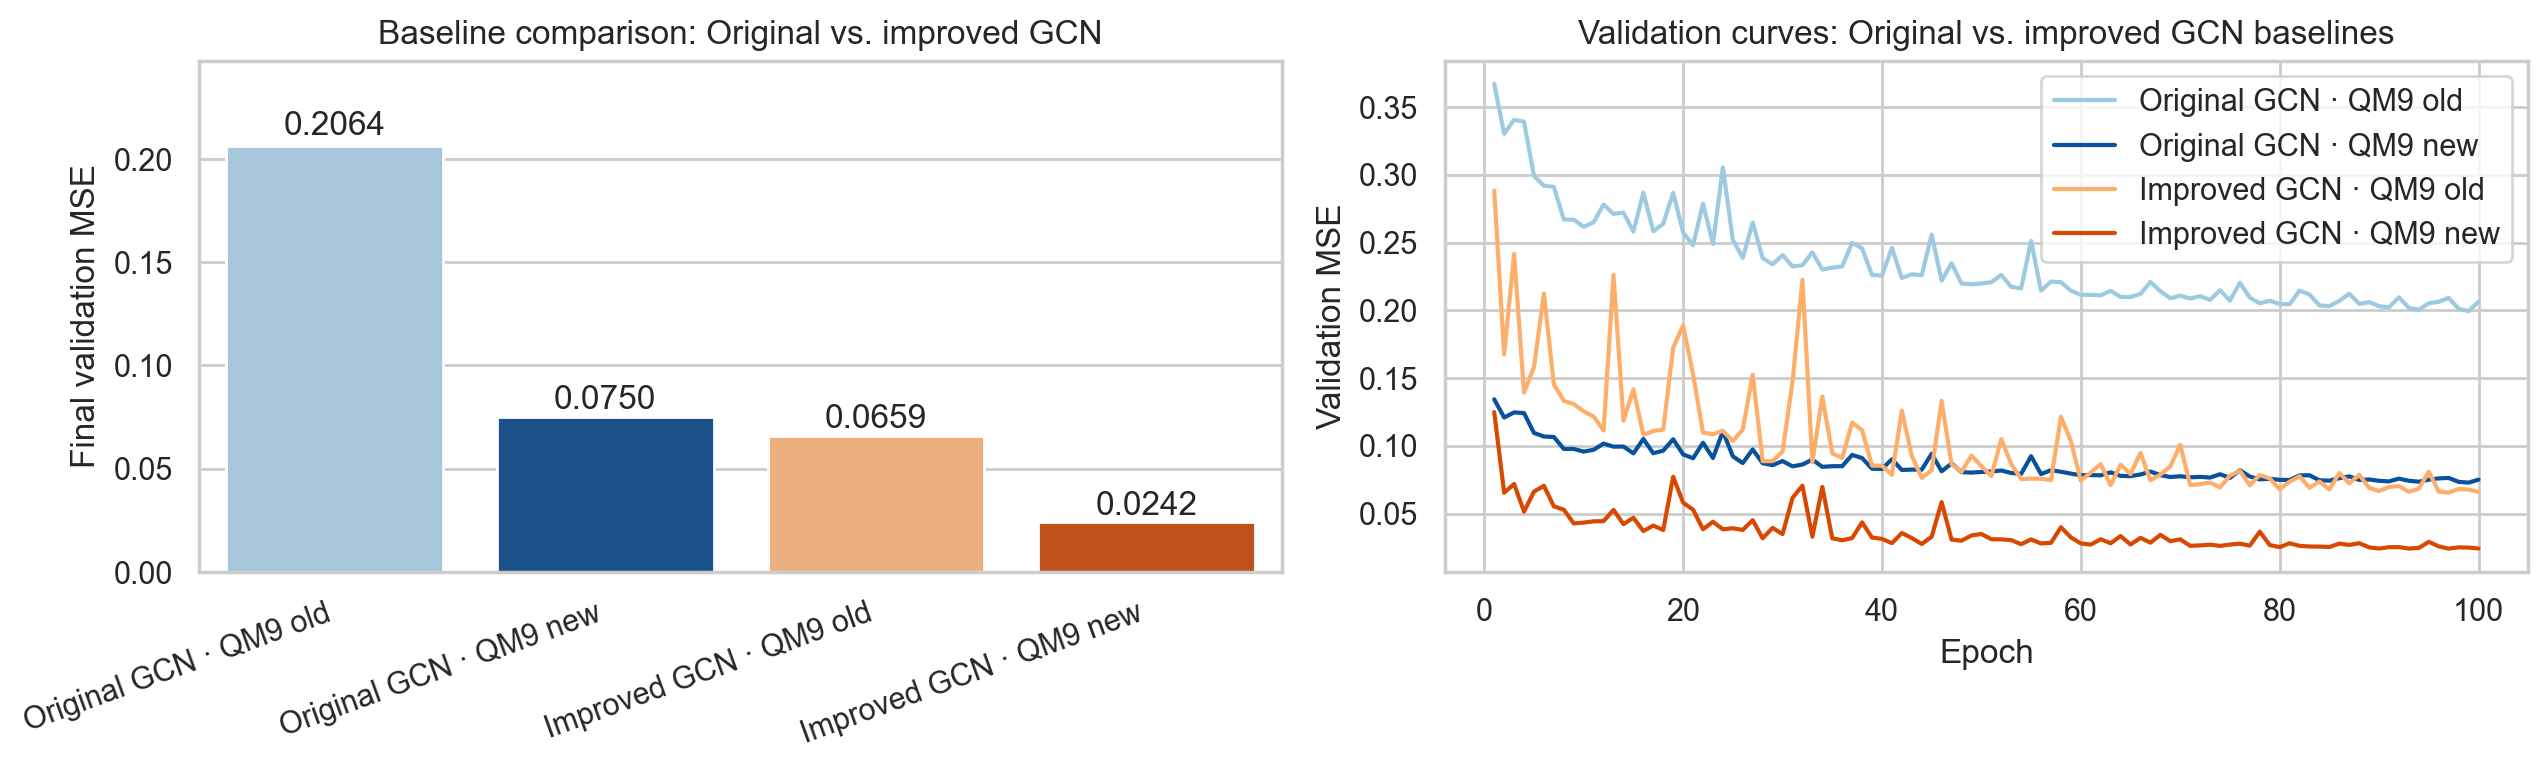

In [111]:
baseline_comparison_records = load_baseline_comparison_records(COMPARE_RESULTS_PATH)
comparison_df = pd.DataFrame(
    [
        {
            "label": rec["label"],
            "model": rec["model"],
            "dataset_variant": rec["dataset_variant"],
            "final_val_mse": rec["final_val_mse"],
        }
        for rec in baseline_comparison_records
    ]
)
comparison_df

labels = [rec["label"] for rec in baseline_comparison_records]
color_map = {
    "Original GCN · QM9 old": "#9ecae1",   # light blue
    "Original GCN · QM9 new": "#08519c",   # dark blue
    "Improved GCN · QM9 old": "#fdae6b",   # light orange
    "Improved GCN · QM9 new": "#d94801",   # dark orange
}
colors = [color_map[label] for label in labels]
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

bar_ax = axes[0]
sns.barplot(
    ax=bar_ax,
    data=comparison_df,
    x="label",
    y="final_val_mse",
    order=labels,
    palette=color_map,
)
bar_ax.set_xlabel("")
bar_ax.set_ylabel("Final validation MSE")
bar_ax.set_title("Baseline comparison: Original vs. improved GCN")
bar_ax.set_xticklabels(labels, rotation=20, ha="right")
for patch, metric in zip(bar_ax.patches, comparison_df.set_index("label").loc[labels, "final_val_mse"]):
    height = patch.get_height()
    bar_ax.text(patch.get_x() + patch.get_width() / 2, height * 1.01, f"{metric:.4f}", ha="center", va="bottom")
bar_ax.set_ylim(0, comparison_df["final_val_mse"].max() * 1.2)

hist_ax = axes[1]
for rec in baseline_comparison_records:
    history_df = rec["history"]
    color = color_map[rec["label"]]
    hist_ax.plot(history_df["epoch"], history_df["val_mse"], label=rec["label"], color=color)
hist_ax.set_xlabel("Epoch")
hist_ax.set_ylabel("Validation MSE")
hist_ax.set_title("Validation curves: Original vs. improved GCN baselines")
hist_ax.legend()

plt.tight_layout()
plt.show()



## 5. Training & evaluation pipeline

Here we train the 3 models on 5 different labeled/unlabeled splits, [0.5,1,2,5,8]. The models are trained for 100 epochs, and then evaluated on the test data. Please refer to the report for more model specifications. 

For reference if you want to run this locally, it took about 30 mins with a 5% subset on a macbook pro m1 using mps as device.


In [112]:
VALIDATION_KEYS = {
    "Supervised Ensemble": ("val_MSE",),
    "Mean Teacher": ("val_MSE_teacher", "val_MSE_student"),
    "n-CPS": ("val_MSE",),
}

TRAINING_LOGS: dict[tuple[str, float], list[dict]] = {}


def run_single_experiment(method_name: str, labeled_fraction: float):
    dm = build_datamodule(labeled_fraction, show_progress=ENABLE_TQDM)
    trainer, logger = build_trainer(method_name, dm)
    start = time.perf_counter()
    trainer.train(total_epochs=TOTAL_EPOCHS, validation_interval=VALIDATION_INTERVAL)
    duration = time.perf_counter() - start

    summary = collect_summary(logger, VALIDATION_KEYS[method_name])
    test_loader = dm.test_dataloader()

    metrics = {}
    eval_desc = f"{method_name} test @{labeled_fraction*100:.1f}%"
    if method_name == "Mean Teacher":
        metrics["test_MSE_teacher"] = evaluate_on_loader(
            trainer.teacher,
            test_loader,
            dm,
            desc=eval_desc + " (teacher)",
            show_progress=ENABLE_TQDM,
        )
        metrics["test_MSE_student"] = evaluate_on_loader(
            trainer.student,
            test_loader,
            dm,
            desc=eval_desc + " (student)",
            show_progress=ENABLE_TQDM,
        )
    else:
        metrics["test_MSE"] = evaluate_on_loader(
            trainer.models,
            test_loader,
            dm,
            desc=eval_desc,
            show_progress=ENABLE_TQDM,
        )

    record = {
        "method": method_name,
        "labeled_fraction": labeled_fraction,
        "labeled_fraction_pct": labeled_fraction * 100,
        "labeled_samples": len(dm.data_train_labeled),
        "unlabeled_samples": len(dm.data_train_unlabeled),
        "val_samples": len(dm.data_val),
        "test_samples": len(dm.data_test),
        "train_time_s": duration,
        **summary,
        **metrics,
    }

    TRAINING_LOGS[(method_name, labeled_fraction)] = logger.history
    return record


def run_full_sweep():
    records = []
    combos = [(frac, method_name) for frac in LABELED_SPLITS for method_name in TRAINER_SPECS.keys()]
    iterator = progress_iter(combos, desc="Experiments", leave=False) if ENABLE_TQDM else combos
    for frac, method_name in iterator:
        record = run_single_experiment(method_name, frac)
        records.append(record)
    df = pd.DataFrame(records)
    return df


if RUN_EXPERIMENTS:
    results_df = run_full_sweep()
    results_df.to_csv(RESULTS_CACHE, index=False)
else:
    if RESULTS_CACHE.exists():
        results_df = pd.read_csv(RESULTS_CACHE)
        print(f"Loaded cached results from {RESULTS_CACHE}")
    else:
        raise FileNotFoundError("No cached results available; set RUN_EXPERIMENTS=True to generate them.")

results_df.sort_values(["method", "labeled_fraction_pct"], inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df



Loaded cached results from /Users/Magnus/Documents/7. sem/Deep Learnig/Project-2-gnn-and-semi_supervised/outputs/notebooks/semisupervised_results.csv


,method,labeled_fraction,labeled_fraction_pct,labeled_samples,unlabeled_samples,val_samples,test_samples,train_time_s,val_MSE,test_MSE,val_MSE_teacher,val_MSE_student,test_MSE_teacher,test_MSE_student
0,Mean Teacher,0.005,0.5,6,1039,130,133,40.137262,NaN,NaN,7.623645,0.554951,7.545772,0.458299
1,Mean Teacher,0.010,1.0,13,1033,130,132,41.402372,NaN,NaN,17.159060,0.746121,17.175598,0.588874
2,Mean Teacher,0.020,2.0,26,1020,130,132,43.771920,NaN,NaN,19.193577,0.610336,19.273235,0.473541
3,Mean Teacher,0.050,5.0,65,981,130,132,119.126376,NaN,NaN,2.598825,0.154251,2.619151,0.134843
4,Mean Teacher,0.080,8.0,104,941,130,133,234.175119,NaN,NaN,1.879427,0.131909,1.841836,0.142368
5,Supervised Ensemble,0.005,0.5,6,1039,130,133,20.837048,0.408339,0.300699,NaN,NaN,NaN,NaN
6,Supervised Ensemble,0.010,1.0,13,1033,130,132,17.193427,1.064866,0.924882,NaN,NaN,NaN,NaN
7,Supervised Ensemble,0.020,2.0,26,1020,130,132,16.553606,0.596697,0.533956,NaN,NaN,NaN,NaN
8,Supervised Ensemble,0.050,5.0,65,981,130,132,39.021049,0.394353,0.379657,NaN,NaN,NaN,NaN
9,Supervised Ensemble,0.080,8.0,104,941,130,133,89.600208,0.139870,0.133831,NaN,NaN,NaN,NaN


### Visual comparison across labeled splits

Below we see the 3 model performances on the different labeled/unlabeled splits.


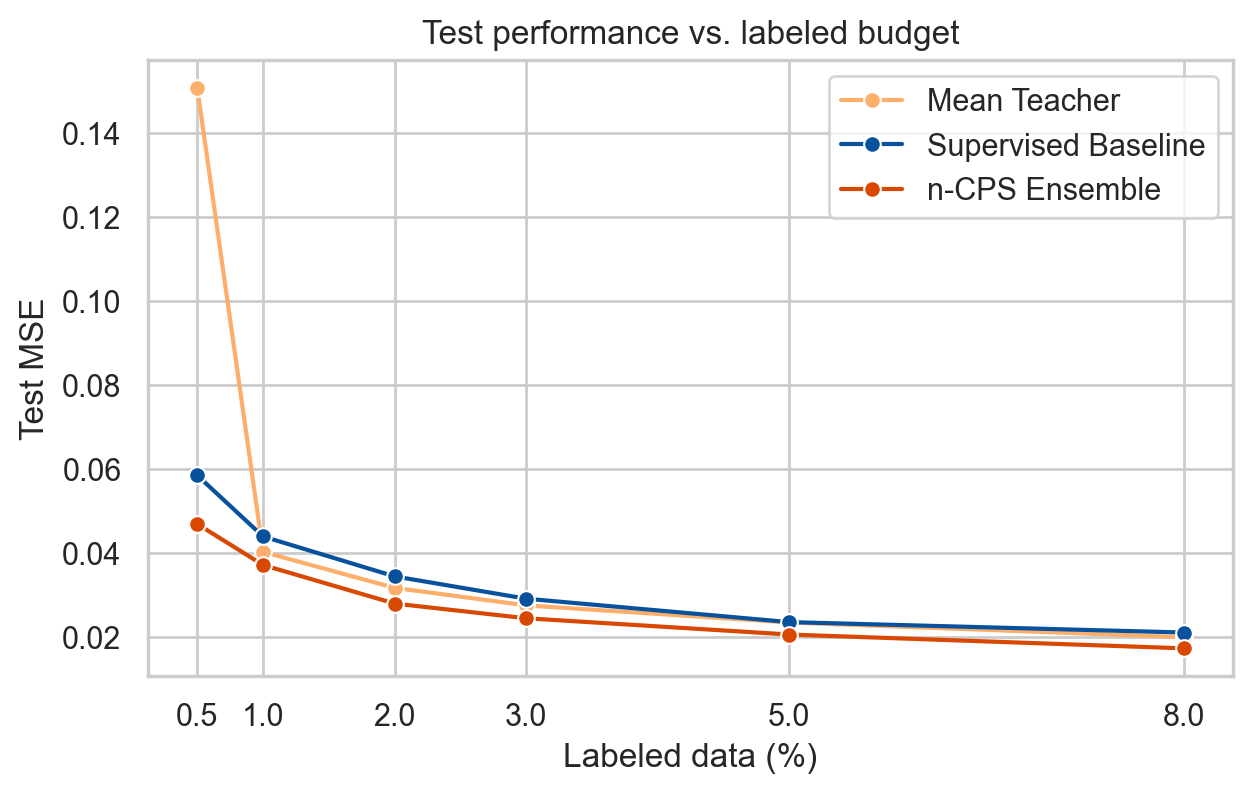

,method,labeled_fraction_pct,plot_metric,train_time_s
0,Mean Teacher,0.5,0.150726,NaN
1,Mean Teacher,1.0,0.040356,NaN
2,Mean Teacher,2.0,0.031803,NaN
3,Mean Teacher,3.0,0.027638,NaN
4,Mean Teacher,5.0,0.023562,NaN
5,Mean Teacher,8.0,0.020056,NaN
6,Supervised Baseline,0.5,0.058580,NaN
7,Supervised Baseline,1.0,0.044039,NaN
8,Supervised Baseline,2.0,0.034541,NaN
9,Supervised Baseline,3.0,0.029228,NaN


In [116]:

if RUN_EXPERIMENTS:
    plot_df = results_df.copy()
    plot_df["plot_metric"] = np.where(
        plot_df["method"] == "Mean Teacher",
        plot_df["test_MSE_teacher"],
        plot_df["test_MSE"],
    )
else:
    plot_df = load_label_sweep_plot_df(LABEL_SWEEP_RESULTS)

if "train_time_s" not in plot_df:
    plot_df["train_time_s"] = np.nan

method_colors = {
    "Supervised Ensemble": "#08519c",  # dark blue
    "Mean Teacher": "#fdae6b",        # light orange
    "n-CPS": "#d94801",               # dark orange
}
method_color_aliases = {
    "Supervised Ensemble": "Supervised Ensemble",
    "Supervised Baseline": "Supervised Ensemble",
    "Mean Teacher": "Mean Teacher",
    "n-CPS": "n-CPS",
    "n-CPS Ensemble": "n-CPS",
}
palette = {
    method: method_colors.get(method_color_aliases.get(method, method), "#444444")
    for method in plot_df["method"].unique()
}
plt.figure(figsize=(7, 4))
sns.lineplot(
    data=plot_df,
    x="labeled_fraction_pct",
    y="plot_metric",
    hue="method",
    palette=palette,
    marker="o",
)
plt.xlabel("Labeled data (%)")
plt.ylabel("Test MSE")
plt.title("Test performance vs. labeled budget")
plt.legend(title=None)
plt.xticks(sorted(plot_df["labeled_fraction_pct"].unique()))
plt.show()

plot_df[["method", "labeled_fraction_pct", "plot_metric", "train_time_s"]]



## 6. Statistical tests over labeled fractions

Treating each labeled fraction as a repeated measurement, we can apply the Friedman test (non-parametric repeated-measures ANOVA) to determine whether the three methods behave differently. We then follow up with pairwise Wilcoxon signed-rank tests.


In [ ]:
pivot = plot_df.pivot(index="labeled_fraction_pct", columns="method", values="plot_metric")
friedman_stat, friedman_p = stats.friedmanchisquare(*pivot.values.T)
print(f"Friedman chi^2 = {friedman_stat:.3f}, p-value = {friedman_p:.4f}")

pairwise = []
comparisons = list(combinations(pivot.columns, 2))
alpha = 0.05
bonferroni_factor = len(comparisons)
for m1, m2 in comparisons:
    try:
        stat_val, p_val = stats.wilcoxon(pivot[m1], pivot[m2])
    except ValueError:
        stat_val, p_val = np.nan, np.nan
    corrected_p = min(p_val * bonferroni_factor, 1.0) if not np.isnan(p_val) else np.nan
    pairwise.append({
        "method_a": m1,
        "method_b": m2,
        "wilcoxon_stat": stat_val,
        "p_value": p_val,
        "p_value_bonferroni": corrected_p,
        "significant@0.05": corrected_p < alpha if not np.isnan(corrected_p) else np.nan,
    })

pairwise_df = pd.DataFrame(pairwise)
pairwise_df



Friedman chi^2 = 10.333, p-value = 0.0057


,method_a,method_b,wilcoxon_stat,p_value,p_value_bonferroni,significant@0.05
0,Mean Teacher,Supervised Baseline,6.0,0.43750,1.00000,False
1,Mean Teacher,n-CPS Ensemble,0.0,0.03125,0.09375,False
2,Supervised Baseline,n-CPS Ensemble,0.0,0.03125,0.09375,False


## 7. Summary

Sections 1–6 reconstruct the QM9 semi-supervised pipeline: data loading via `src/qm9.py`, tuned GCN trainers from `src/trainer.py`, labeled-fraction sweeps, cached-vs-live comparisons, and statistical tests. Highlights:

- n-CPS remains the safest bet at the ultra-low-label regime (≈0.0366 test MSE at 1% labels).
- Mean Teacher overtakes the supervised ensemble once ≥1% labels are available, though the advantage shrinks as the label budget grows.
- The Friedman/Wilcoxon tests show the three trainers behave differently for this configuration (χ²≈10.3, p≈0.006), so method choice matters.


